# Equations of Motion for a Rigid Body


In [2]:
:dep ndarray = { version = "0.16.1" }
:dep plotly = { version = "0.10.0" }
:dep nalgebra = { version = "0.33.1" }
extern crate ndarray;
extern crate plotly;
extern crate nalgebra;

use ndarray::{Array, Array2};
use nalgebra::{SMatrix, SVector};
use plotly::common::Mode;
use plotly::layout::{Layout};
use plotly::{Plot, Scatter};

In [107]:
#[derive(Debug)]
struct RigidBody {
    mass: f64,
    I: SMatrix::<f64, 3, 3>,
    I_inv: SMatrix::<f64, 3, 3>,
    
    // Define the state vector
    // 0 u
    // 1 v
    // 2 w
    // 3 p
    // 4 q
    // 5 r
    // 6 q0
    // 7 q1
    // 8 q2
    // 9 q3
    // 10 x
    // 11 y
    // 12 z
    x: SVector::<f64, 13>,
}

impl RigidBody {
    fn new(I: SMatrix::<f64, 3, 3>, mass: f64, initial_state: SVector::<f64, 13>) -> Self {

        let I_inv = I.try_inverse().unwrap();
        
        Self {
            mass,
            I,
            I_inv,
            x: initial_state,
        }
    }

    fn normalize_quaternion(&mut self) {
        let mut q = SVector::<f64, 4>::new(self.x[6], self.x[7], self.x[8], self.x[9]);
        q.normalize();

        self.x[6] = q[0];
        self.x[7] = q[1];
        self.x[8] = q[2];
        self.x[9] = q[3];
    }

    fn calculate_state_derivative(&self, x: &SVector::<f64, 13>, F: &SVector::<f64, 3>, M: &SVector::<f64, 3>) -> SVector::<f64, 13> {
        // I'll try to do the coriolis stuff here
        let omega = SVector::<f64, 3>::new(x[3], x[4], x[5]);
        let part1 = self.I * omega;
        let coriolis = omega.cross(&part1);
        
        let omega_dot = self.I_inv * (M - coriolis);

        let mut x_dot = SVector::<f64, 13>::zeros();
        x_dot[0] = (F[0] / self.mass) + x[2] * x[4] - x[1] * x[5];
        x_dot[1] = (F[1] / self.mass) + x[0] * x[5] - x[2] * x[3];
        x_dot[2] = (F[2] / self.mass) + x[1] * x[3] - x[0] * x[4];
        x_dot[3] = omega_dot[0];
        x_dot[4] = omega_dot[1];
        x_dot[5] = omega_dot[2];
        x_dot[6] = - 0.5 * (x[7] * x[3] + x[8] * x[4] + x[9] * x[5]); // q0
        x_dot[7] = 0.5 * (x[6] * x[3] + x[8] * x[5] - x[9] * x[4]);   // q1
        x_dot[8] = 0.5 * (x[6] * x[4] + x[9] * x[3] - x[7] * x[5]);   // q2
        x_dot[9] = 0.5 * (x[6] * x[5] + x[7] * x[4] - x[8] * x[3]);   // q3
        x_dot
    }

    fn propagate_state(&self, dt: f64, F: &SVector::<f64, 3>, M: &SVector::<f64, 3>) -> SVector::<f64, 13> {
        // Runge Kutta

        let x = self.x.clone();
        let k1 = self.calculate_state_derivative(&x, F, M);
        
        let x1 = x + (0.5 * dt) * k1;
        let k2 = self.calculate_state_derivative(&x1, F, M);
        
        let x2 = x + (0.5 * dt) * k2;
        let k3 = self.calculate_state_derivative(&x2, F, M);
        
        let x3 = x + dt * k3;
        let k4 = self.calculate_state_derivative(&x3, F, M);
        
        let x4 = x + (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4);

        x4
        
    }

    fn run(&mut self, steps: usize, dt: f64) -> (ndarray::Array1<f64>, Array2<f64>) {
        let mut time_series: ndarray::Array1<f64> = ndarray::Array1::<f64>::zeros(steps);
        let mut output_series: Array2<f64> = Array2::<f64>::zeros((steps, 13));
    
        let Fx = 0.0; // N
        let Fy = 0.0; // N
        let Fz = 0.0; // N
        
        let Mx = 0.0;
        let My = 0.0;
        let Mz = 0.0;
        
        let F = SVector::<f64, 3>::new(Fx, Fy, Fz);
        let M = SVector::<f64, 3>::new(Mx, My, Mz);

        let mut t = 0.0;
        for i in 0..steps {
            self.x = self.propagate_state(dt, &F, &M);
            self.normalize_quaternion();

            time_series[i] = t;
            let x_slice = self.x.as_slice();
            let x_view = ndarray::Array1::from(x_slice.to_vec());
            output_series.slice_mut(ndarray::s![i, 0..]).assign(&x_view);
            
            t += dt;
        }

        (time_series, output_series)
    }
}

In [108]:
let mass = 10.0;  // kg
let Ixx = 0.0167; // kg m^2
let Iyy = 0.0833; // kg m^2
let Izz = 0.125;  // kg m^2
let Ixy = 0.0;
let Ixz = 0.0;
let Iyz = 0.0;

let I = SMatrix::<f64, 3, 3>::new(
    Ixx, -Ixy, -Ixz,
    -Ixy, Iyy, -Iyz,
    -Ixz, -Iyz, Izz
);

let I_inv = I.try_inverse().unwrap();

In [112]:
let mut initial_state = SVector::<f64, 13>::zeros();
// quaternion
initial_state[6] = 1.0; // q0
initial_state[0] = 0.0; // u
initial_state[5] = 180.0 * (std::f64::consts::PI / 180.0);
let mut body = RigidBody::new(I, mass, initial_state);
let (time, output) = body.run(201, 0.02);
let time: Vec<f64> = time.to_vec();
let u: Vec<f64> = output.column(0).to_vec();
let v: Vec<f64> = output.column(1).to_vec();
let w: Vec<f64> = output.column(2).to_vec();
let p: Vec<f64> = output.column(3).to_vec();
let q: Vec<f64> = output.column(4).to_vec();
let r: Vec<f64> = output.column(5).to_vec();
let q0: Vec<f64> = output.column(6).to_vec();
let q1: Vec<f64> = output.column(7).to_vec();
let q2: Vec<f64> = output.column(8).to_vec();
let q3: Vec<f64> = output.column(9).to_vec();


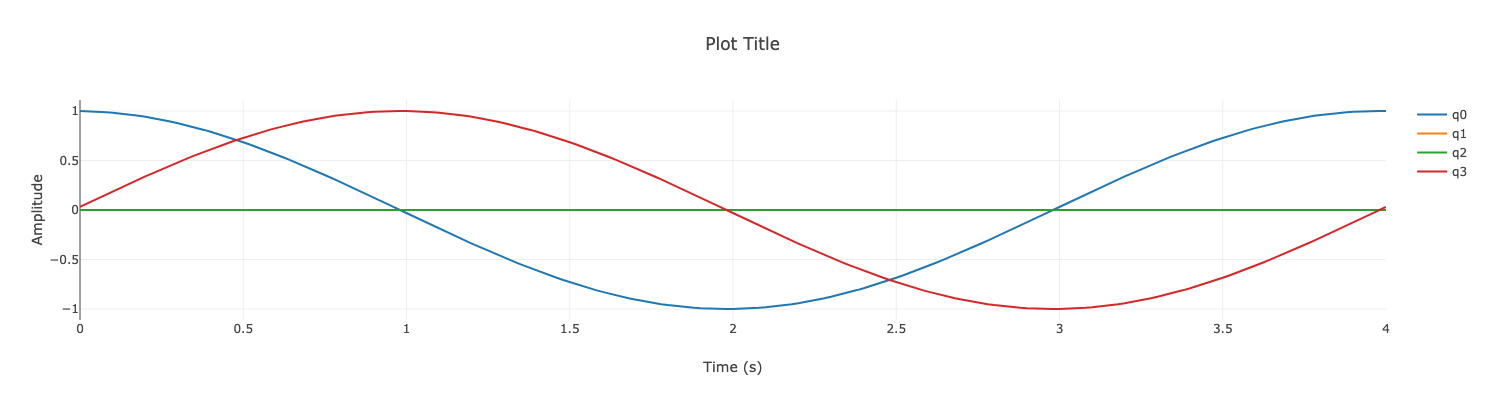

In [113]:
use plotly::*;
// Plot position vs. time
let mut plot = Plot::new();
let trace = Scatter::new(time.clone(), q0.clone())
    .mode(plotly::common::Mode::Lines)
    .name("q0");
plot.add_trace(trace);

let trace = Scatter::new(time.clone(), q1.clone())
    .mode(plotly::common::Mode::Lines)
    .name("q1");
plot.add_trace(trace);

let trace = Scatter::new(time.clone(), q2.clone())
    .mode(plotly::common::Mode::Lines)
    .name("q2");
plot.add_trace(trace);

let trace = Scatter::new(time.clone(), q3.clone())
    .mode(plotly::common::Mode::Lines)
    .name("q3");
plot.add_trace(trace);

// Set layout properties
let layout = Layout::new()
    .title("Plot Title")
    .x_axis(plotly::layout::Axis::new().title("Time (s)"))
    .y_axis(plotly::layout::Axis::new().title("Amplitude"))
    .height(400)
    .width(800);

plot.set_layout(layout);
plot.lab_display();